In [ ]:
import numpy as np
import pandas as pd
import nltk
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords, wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Load datasets
gossipcop_fake = pd.read_csv('gossipcop_fake.csv')
gossipcop_real = pd.read_csv('gossipcop_real.csv')
politifact_fake = pd.read_csv('politifact_fake.csv')
politifact_real = pd.read_csv('politifact_real.csv')

In [ ]:
# Combine datasets
gossipcop_fake['label'] = 0
gossipcop_real['label'] = 1
politifact_fake['label'] = 0
politifact_real['label'] = 1

data = pd.concat([gossipcop_fake, gossipcop_real, politifact_fake, politifact_real], ignore_index=True)

# Data preprocessing
stop_words = set(stopwords.words('english'))

In [ ]:
def clean_text(text):
    words = text.lower().split()
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

data['cleaned_title'] = data['title'].apply(clean_text)

# Text Data Augmentation Functions
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(sentence, n):
    words = sentence.split()
    if len(words) == 0:
        return sentence
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    sentence = ' '.join(new_words)
    return sentence

def random_insertion(sentence, n):
    words = sentence.split()
    if len(words) == 0:
        return sentence
    for _ in range(n):
        add_word(words)
    return ' '.join(words)

def add_word(words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = words[random.randint(0, len(words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(words)-1)
    words.insert(random_idx, random_synonym)

def random_swap(sentence, n):
    words = sentence.split()
    if len(words) == 0:
        return sentence
    for _ in range(n):
        words = swap_word(words)
    return ' '.join(words)

def swap_word(words):
    random_idx_1 = random.randint(0, len(words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(words)-1)
        counter += 1
        if counter > 3:
            return words
    words[random_idx_1], words[random_idx_2] = words[random_idx_2], words[random_idx_1]
    return words

def random_deletion(sentence, p):
    words = sentence.split()
    if len(words) <= 1:  # If there's only one word or none, return the original sentence
        return ' '.join(words)

    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    if len(new_words) == 0:
        return ' '.join([random.choice(words)])  # Return a random word from original words if all deleted

    return ' '.join(new_words)

def augment_sentence(sentence):
    augmented_sentences = []
    augmented_sentences.append(synonym_replacement(sentence, n=2))
    augmented_sentences.append(random_insertion(sentence, n=2))
    augmented_sentences.append(random_swap(sentence, n=2))
    augmented_sentences.append(random_deletion(sentence, p=0.2))
    return augmented_sentences

# Apply data augmentation
augmented_data = []
for _, row in data.iterrows():
    augmented_sentences = augment_sentence(row['cleaned_title'])
    for aug_sentence in augmented_sentences:
        augmented_data.append({'title': aug_sentence, 'label': row['label']})

augmented_df = pd.DataFrame(augmented_data)

# Combine original and augmented data
combined_data = pd.concat([data[['cleaned_title', 'label']].rename(columns={'cleaned_title': 'title'}), augmented_df], ignore_index=True)

In [ ]:
# Tokenization and padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(combined_data['title'])
sequences = tokenizer.texts_to_sequences(combined_data['title'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, combined_data['label'], test_size=0.2, random_state=42)

# Model definition
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))




##batch_size=512

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model with validation split
history = model.fit(X_train, y_train, epochs=20, batch_size=512, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/20
145/145 [==============================] - 39s 207ms/step - loss: 2.1189 - accuracy: 0.7831 - val_loss: 0.5271 - val_accuracy: 0.8270
Epoch 2/20
145/145 [==============================] - 11s 78ms/step - loss: 0.4021 - accuracy: 0.8435 - val_loss: 0.3677 - val_accuracy: 0.8454
Epoch 3/20
145/145 [==============================] - 7s 47ms/step - loss: 0.3494 - accuracy: 0.8537 - val_loss: 0.3605 - val_accuracy: 0.8440
Epoch 4/20
145/145 [==============================] - 6s 42ms/step - loss: 0.3317 - accuracy: 0.8635 - val_loss: 0.3427 - val_accuracy: 0.8557
Epoch 5/20
145/145 [==============================] - 6s 43ms/step - loss: 0.3076 - accuracy: 0.8742 - val_loss: 0.3380 - val_accuracy: 0.8576
Epoch 6/20
145/145 [==============================] - 6s 41ms/step - loss: 0.2953 - accuracy: 0.8800 - val_loss: 0.3347 - val_accuracy: 0.8587
Epoch 7/20
145/145 [==============================] - 6s 42ms/step - loss: 0.2943 - accuracy: 0.8806 - val_loss: 0.3550 - val_accuracy: 0.8

In [ ]:
# Save the trained model
model.save('fake_news_detection_model_512.h5')
# Save only the weights
model.save_weights('fake_news_detection_weights_512.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


725/725 [==============================] - 7s 10ms/step - loss: 0.3178 - accuracy: 0.8702
Model Accuracy: 0.8701931238174438


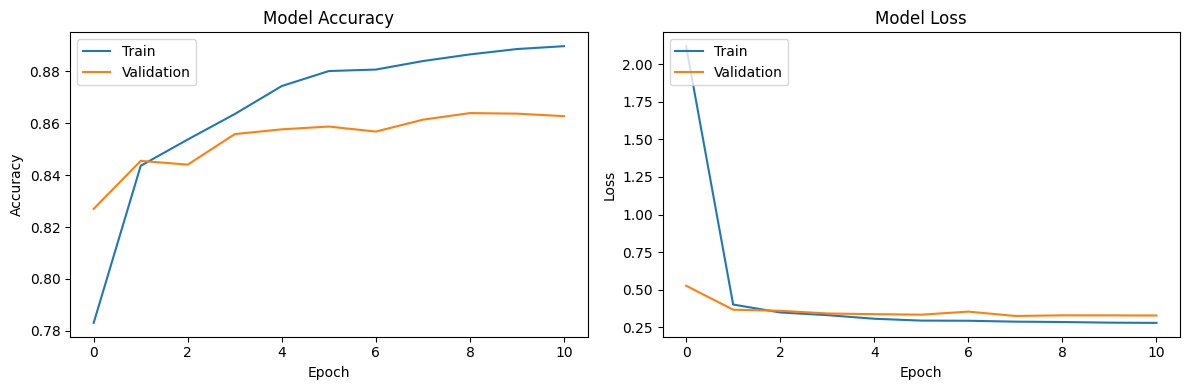

725/725 [==============================] - 6s 7ms/step
              precision    recall  f1-score   support

           0       0.77      0.69      0.73      5794
           1       0.90      0.93      0.91     17402

    accuracy                           0.87     23196
   macro avg       0.83      0.81      0.82     23196
weighted avg       0.87      0.87      0.87     23196



In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy}')

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_history(history)

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

In [ ]:
# Define a function to preprocess and predict
def predict_fake_news(statement, model, tokenizer, max_len):
    def clean_text(text):
        stop_words = set(stopwords.words('english'))
        words = text.lower().split()
        words = [word for word in words if word.isalpha() and word not in stop_words]
        return ' '.join(words)

    # Preprocess the statement
    cleaned_statement = clean_text(statement)
    sequence = tokenizer.texts_to_sequences([cleaned_statement])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    # Predict
    prediction = model.predict(padded_sequence)[0][0]
    return 'Real' if prediction >= 0.5 else 'Fake'

# Function to predict and display results for multiple statements
def test_multiple_statements(statements, model, tokenizer, max_len):
    for statement in statements:
        result = predict_fake_news(statement, model, tokenizer, max_len)
        print(f'The statement: "{statement}" is classified as: {result}')


# List of statements to test
test_statements = [
    "NASA confirms liquid water on Mars",
    "Celebrity endorses miracle weight loss pill",
    "New technology promises to solve world hunger",
    "Aliens have landed on Earth, says government",
    "Economic growth predicted to soar in 2025",
    "Scientists discover new species of dinosaur",
    "Study shows chocolate cures cancer",
    "Politician caught in corruption scandal",
    "Local hero saves family from burning building",
    "New movie breaks box office records",
    "Scientists prove that drinking bleach can cure COVID-19.",
"Millions of illegal votes were cast in the last election, says anonymous source.",
"New study claims that climate change is a hoax perpetuated by scientists for profit.",
"Elvis Presley spotted working as a cashier in a small-town grocery store.",
"Alien spacecraft discovered on the dark side of the moon, NASA confirms.",
"World leaders gather secretly to plan global domination, leaked documents reveal.",
"New app guarantees to make you a millionaire overnight with just a few clicks.",
"Facebook to start charging users $2.99/month for access to their accounts.",
"Vaccines proven to cause autism, says disgraced former doctor.",
"Breaking: Loch Ness Monster captured alive, shocking footage released."
]

# Test the model with multiple statements
test_multiple_statements(test_statements, model, tokenizer, max_len)


1/1 [==============================] - 0s 33ms/step
The statement: "NASA confirms liquid water on Mars" is classified as: Real
1/1 [==============================] - 0s 34ms/step
The statement: "Celebrity endorses miracle weight loss pill" is classified as: Real
1/1 [==============================] - 0s 31ms/step
The statement: "New technology promises to solve world hunger" is classified as: Real
1/1 [==============================] - 0s 49ms/step
The statement: "Aliens have landed on Earth, says government" is classified as: Real
1/1 [==============================] - 0s 41ms/step
The statement: "Economic growth predicted to soar in 2025" is classified as: Real
1/1 [==============================] - 0s 36ms/step
The statement: "Scientists discover new species of dinosaur" is classified as: Real
1/1 [==============================] - 0s 32ms/step
The statement: "Study shows chocolate cures cancer" is classified as: Real
1/1 [==============================] - 0s 35ms/step
The statement

##batch_size=128

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model with validation split
history = model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/20
291/291 [==============================] - 25s 61ms/step - loss: 1.3589 - accuracy: 0.7509 - val_loss: 0.4193 - val_accuracy: 0.8350
Epoch 2/20
291/291 [==============================] - 8s 28ms/step - loss: 0.3783 - accuracy: 0.8548 - val_loss: 0.3667 - val_accuracy: 0.8502
Epoch 3/20
291/291 [==============================] - 7s 23ms/step - loss: 0.3290 - accuracy: 0.8781 - val_loss: 0.3417 - val_accuracy: 0.8632
Epoch 4/20
291/291 [==============================] - 7s 24ms/step - loss: 0.3001 - accuracy: 0.8906 - val_loss: 0.3372 - val_accuracy: 0.8668
Epoch 5/20
291/291 [==============================] - 10s 36ms/step - loss: 0.2784 - accuracy: 0.9002 - val_loss: 0.3318 - val_accuracy: 0.8766
Epoch 6/20
291/291 [==============================] - 9s 30ms/step - loss: 0.4581 - accuracy: 0.8615 - val_loss: 0.4348 - val_accuracy: 0.8681
Epoch 7/20
291/291 [==============================] - 9s 31ms/step - loss: 0.3842 - accuracy: 0.8825 - val_loss: 0.4164 - val_accuracy: 0.85

364/364 [==============================] - 3s 8ms/step - loss: 0.3396 - accuracy: 0.8754
Model Accuracy: 0.8754191398620605


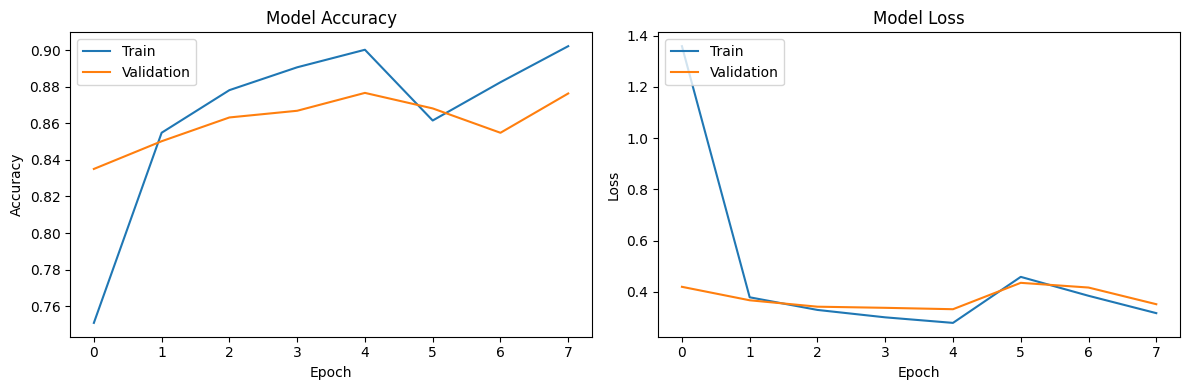

364/364 [==============================] - 4s 7ms/step
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      4030
           1       0.91      0.90      0.90      7601

    accuracy                           0.88     11631
   macro avg       0.86      0.86      0.86     11631
weighted avg       0.88      0.88      0.88     11631



In [ ]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy}')

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_history(history)

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

In [ ]:
# Save the trained model
model.save('fake_news_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Define a function to preprocess and predict
def predict_fake_news(statement, model, tokenizer, max_len):
    def clean_text(text):
        stop_words = set(stopwords.words('english'))
        words = text.lower().split()
        words = [word for word in words if word.isalpha() and word not in stop_words]
        return ' '.join(words)

    # Preprocess the statement
    cleaned_statement = clean_text(statement)
    sequence = tokenizer.texts_to_sequences([cleaned_statement])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    # Predict
    prediction = model.predict(padded_sequence)[0][0]
    return 'Real' if prediction >= 0.5 else 'Fake'

# Function to predict and display results for multiple statements
def test_multiple_statements(statements, model, tokenizer, max_len):
    for statement in statements:
        result = predict_fake_news(statement, model, tokenizer, max_len)
        print(f'The statement: "{statement}" is classified as: {result}')


# List of statements to test
test_statements = [
    "NASA confirms liquid water on Mars",
    "Celebrity endorses miracle weight loss pill",
    "New technology promises to solve world hunger",
    "Aliens have landed on Earth, says government",
    "Economic growth predicted to soar in 2025",
    "Scientists discover new species of dinosaur",
    "Study shows chocolate cures cancer",
    "Politician caught in corruption scandal",
    "Local hero saves family from burning building",
    "New movie breaks box office records",
    "Scientists prove that drinking bleach can cure COVID-19.",
"Millions of illegal votes were cast in the last election, says anonymous source.",
"New study claims that climate change is a hoax perpetuated by scientists for profit.",
"Elvis Presley spotted working as a cashier in a small-town grocery store.",
"Alien spacecraft discovered on the dark side of the moon, NASA confirms.",
"World leaders gather secretly to plan global domination, leaked documents reveal.",
"New app guarantees to make you a millionaire overnight with just a few clicks.",
"Facebook to start charging users $2.99/month for access to their accounts.",
"Vaccines proven to cause autism, says disgraced former doctor.",
"Breaking: Loch Ness Monster captured alive, shocking footage released."
]

# Test the model with multiple statements
test_multiple_statements(test_statements, model, tokenizer, max_len)


1/1 [==============================] - 0s 22ms/step
The statement: "NASA confirms liquid water on Mars" is classified as: Fake
1/1 [==============================] - 0s 22ms/step
The statement: "Celebrity endorses miracle weight loss pill" is classified as: Real
1/1 [==============================] - 0s 20ms/step
The statement: "New technology promises to solve world hunger" is classified as: Real
1/1 [==============================] - 0s 21ms/step
The statement: "Aliens have landed on Earth, says government" is classified as: Real
1/1 [==============================] - 0s 21ms/step
The statement: "Economic growth predicted to soar in 2025" is classified as: Real
1/1 [==============================] - 0s 22ms/step
The statement: "Scientists discover new species of dinosaur" is classified as: Real
1/1 [==============================] - 0s 21ms/step
The statement: "Study shows chocolate cures cancer" is classified as: Fake
1/1 [==============================] - 0s 23ms/step
The statement

##batch_size=64

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Epoch 1/20
1160/1160 [==============================] - 46s 31ms/step - loss: 0.6246 - accuracy: 0.8260 - val_loss: 0.3503 - val_accuracy: 0.8547
Epoch 2/20
1160/1160 [==============================] - 25s 22ms/step - loss: 0.3217 - accuracy: 0.8685 - val_loss: 0.3411 - val_accuracy: 0.8543
Epoch 3/20
1160/1160 [==============================] - 25s 22ms/step - loss: 0.3073 - accuracy: 0.8740 - val_loss: 0.3283 - val_accuracy: 0.8609
Epoch 4/20
1160/1160 [==============================] - 25s 21ms/step - loss: 0.2975 - accuracy: 0.8785 - val_loss: 0.3369 - val_accuracy: 0.8595
Epoch 5/20
1160/1160 [==============================] - 25s 21ms/step - loss: 0.2946 - accuracy: 0.8800 - val_loss: 0.3293 - val_accuracy: 0.8618
Epoch 6/20
1160/1160 [==============================] - 25s 21ms/step - loss: 0.2880 - accuracy: 0.8815 - val_loss: 0.3250 - val_accuracy: 0.8629
Epoch 7/20
1160/1160 [==============================] - 25s 22ms/step - loss: 0.2880 - accuracy: 0.8824 - val_loss: 0.3322 -

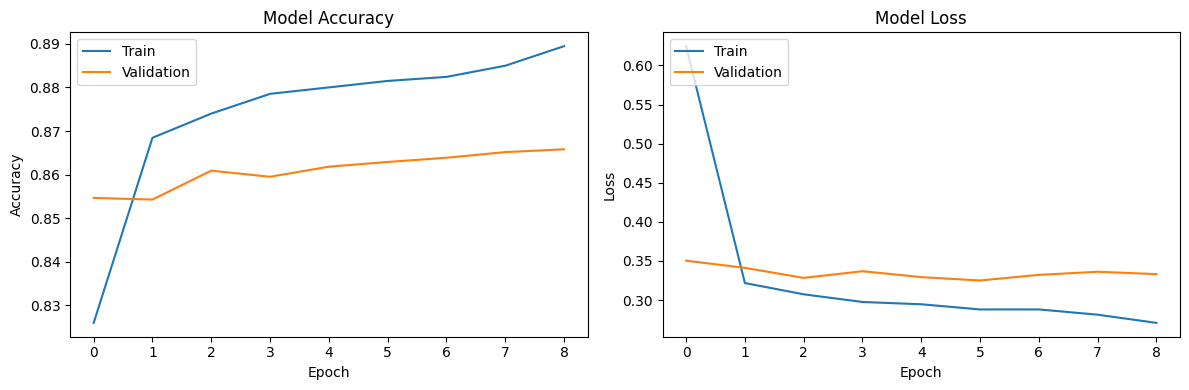

725/725 [==============================] - 7s 7ms/step
              precision    recall  f1-score   support

           0       0.77      0.68      0.72      5794
           1       0.90      0.93      0.91     17402

    accuracy                           0.87     23196
   macro avg       0.83      0.80      0.82     23196
weighted avg       0.87      0.87      0.87     23196

1/1 [==============================] - 0s 23ms/step
The statement: "NASA confirms liquid water on Mars" is classified as: Real
1/1 [==============================] - 0s 23ms/step
The statement: "Celebrity endorses miracle weight loss pill" is classified as: Real


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 21ms/step
The statement: "New technology promises to solve world hunger" is classified as: Real
1/1 [==============================] - 0s 22ms/step
The statement: "Aliens have landed on Earth, says government" is classified as: Real
1/1 [==============================] - 0s 22ms/step
The statement: "Economic growth predicted to soar in 2025" is classified as: Real
1/1 [==============================] - 0s 21ms/step
The statement: "Scientists discover new species of dinosaur" is classified as: Real
1/1 [==============================] - 0s 22ms/step
The statement: "Study shows chocolate cures cancer" is classified as: Real
1/1 [==============================] - 0s 23ms/step
The statement: "Politician caught in corruption scandal" is classified as: Fake
1/1 [==============================] - 0s 30ms/step
The statement: "Local hero saves family from burning building" is classified as: Real
1/1 [==============================] - 0s 25ms/step
The st

In [ ]:
import numpy as np
import pandas as pd
import nltk
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import stopwords, wordnet

# Load datasets
gossipcop_fake = pd.read_csv('gossipcop_fake.csv')
gossipcop_real = pd.read_csv('gossipcop_real.csv')
politifact_fake = pd.read_csv('politifact_fake.csv')
politifact_real = pd.read_csv('politifact_real.csv')

# Combine datasets
gossipcop_fake['label'] = 0
gossipcop_real['label'] = 1
politifact_fake['label'] = 0
politifact_real['label'] = 1

data = pd.concat([gossipcop_fake, gossipcop_real, politifact_fake, politifact_real], ignore_index=True)

# Data preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(text):
    words = text.lower().split()
    words = [word for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)

data['cleaned_title'] = data['title'].apply(clean_text)

# Text Data Augmentation Functions
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ')
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(sentence, n):
    words = sentence.split()
    if len(words) == 0:
        return sentence
    new_words = words.copy()
    random_word_list = list(set(words))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    sentence = ' '.join(new_words)
    return sentence

def random_insertion(sentence, n):
    words = sentence.split()
    if len(words) == 0:
        return sentence
    for _ in range(n):
        add_word(words)
    return ' '.join(words)

def add_word(words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = words[random.randint(0, len(words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(words)-1)
    words.insert(random_idx, random_synonym)

def random_swap(sentence, n):
    words = sentence.split()
    if len(words) == 0:
        return sentence
    for _ in range(n):
        words = swap_word(words)
    return ' '.join(words)

def swap_word(words):
    random_idx_1 = random.randint(0, len(words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(words)-1)
        counter += 1
        if counter > 3:
            return words
    words[random_idx_1], words[random_idx_2] = words[random_idx_2], words[random_idx_1]
    return words

def random_deletion(sentence, p):
    words = sentence.split()
    if len(words) <= 1:  # If there's only one word or none, return the original sentence
        return ' '.join(words)

    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    if len(new_words) == 0:
        return ' '.join([random.choice(words)])  # Return a random word from original words if all deleted

    return ' '.join(new_words)

def augment_sentence(sentence):
    augmented_sentences = []
    augmented_sentences.append(synonym_replacement(sentence, n=2))
    augmented_sentences.append(random_insertion(sentence, n=2))
    augmented_sentences.append(random_swap(sentence, n=2))
    augmented_sentences.append(random_deletion(sentence, p=0.2))
    return augmented_sentences

# Apply data augmentation
augmented_data = []
for _, row in data.iterrows():
    augmented_sentences = augment_sentence(row['cleaned_title'])
    for aug_sentence in augmented_sentences:
        augmented_data.append({'title': aug_sentence, 'label': row['label']})

augmented_df = pd.DataFrame(augmented_data)

# Combine original and augmented data
combined_data = pd.concat([data[['cleaned_title', 'label']].rename(columns={'cleaned_title': 'title'}), augmented_df], ignore_index=True)

# Tokenization and padding
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(combined_data['title'])
sequences = tokenizer.texts_to_sequences(combined_data['title'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, combined_data['label'], test_size=0.2, random_state=42)

# Model definition
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32, kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model with validation split
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy: {accuracy}')

# Plot training and validation accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_history(history)

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Save the trained model
model.save('fake_news_detection_model.h5')


In [ ]:
# Define a function to preprocess and predict
def predict_fake_news(statement, model, tokenizer, max_len):
    def clean_text(text):
        stop_words = set(stopwords.words('english'))
        words = text.lower().split()
        words = [word for word in words if word.isalpha() and word not in stop_words]
        return ' '.join(words)

    # Preprocess the statement
    cleaned_statement = clean_text(statement)
    sequence = tokenizer.texts_to_sequences([cleaned_statement])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    # Predict
    prediction = model.predict(padded_sequence)[0][0]
    return 'Real' if prediction >= 0.5 else 'Fake'

# Function to predict and display results for multiple statements
def test_multiple_statements(statements, model, tokenizer, max_len):
    for statement in statements:
        result = predict_fake_news(statement, model, tokenizer, max_len)
        print(f'The statement: "{statement}" is classified as: {result}')


# List of statements to test
test_statements = [
    "NASA confirms liquid water on Mars",
    "Celebrity endorses miracle weight loss pill",
    "New technology promises to solve world hunger",
    "Aliens have landed on Earth, says government",
    "Economic growth predicted to soar in 2025",
    "Scientists discover new species of dinosaur",
    "Study shows chocolate cures cancer",
    "Politician caught in corruption scandal",
    "Local hero saves family from burning building",
    "New movie breaks box office records",
    "Scientists prove that drinking bleach can cure COVID-19.",
"Millions of illegal votes were cast in the last election, says anonymous source.",
"New study claims that climate change is a hoax perpetuated by scientists for profit.",
"Elvis Presley spotted working as a cashier in a small-town grocery store.",
"Alien spacecraft discovered on the dark side of the moon, NASA confirms.",
"World leaders gather secretly to plan global domination, leaked documents reveal.",
"New app guarantees to make you a millionaire overnight with just a few clicks.",
"Facebook to start charging users $2.99/month for access to their accounts.",
"Vaccines proven to cause autism, says disgraced former doctor.",
"Breaking: Loch Ness Monster captured alive, shocking footage released."
]

# Test the model with multiple statements
test_multiple_statements(test_statements, model, tokenizer, max_len)


1/1 [==============================] - 0s 88ms/step
The statement: "NASA confirms liquid water on Mars" is classified as: Real
1/1 [==============================] - 0s 37ms/step
The statement: "Celebrity endorses miracle weight loss pill" is classified as: Real
1/1 [==============================] - 0s 41ms/step
The statement: "New technology promises to solve world hunger" is classified as: Real
1/1 [==============================] - 0s 33ms/step
The statement: "Aliens have landed on Earth, says government" is classified as: Real
1/1 [==============================] - 0s 65ms/step
The statement: "Economic growth predicted to soar in 2025" is classified as: Real
1/1 [==============================] - 0s 37ms/step
The statement: "Scientists discover new species of dinosaur" is classified as: Real
1/1 [==============================] - 0s 47ms/step
The statement: "Study shows chocolate cures cancer" is classified as: Real
1/1 [==============================] - 0s 39ms/step
The statement